In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from scipy import stats
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Define dataset path
dataset_zip = "/content/train.zip"
train_dir = "/content/train"

# Check if the dataset is zipped and extract it
if not os.path.exists(train_dir):
    if os.path.exists(dataset_zip):
        print("Extracting dataset...")
        with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
            zip_ref.extractall("/content/")
    else:
        raise FileNotFoundError(f"Dataset not found at {dataset_zip}")

# Check again if the extracted folder exists
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"Extracted dataset folder not found at {train_dir}")

# Define parameters
img_size = (128, 128)
batch_size = 16

# Load the entire dataset (using the whole dataset for training and evaluation)
dataset = image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size, label_mode='int')

# Extract class names
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)

# Normalize images
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

dataset = dataset.map(preprocess).cache().prefetch(tf.data.AUTOTUNE)

# Load pre-trained MobileNetV2 model
base_model = keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False


Extracting dataset...
Found 3352 files belonging to 7 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
# Build CNN model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 5
model.fit(dataset, epochs=epochs)

# Evaluate the model on the dataset
loss, accuracy = model.evaluate(dataset)
print(f"Accuracy on the entire dataset: {accuracy:.2f}")


Epoch 1/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 43s 173ms/step - accuracy: 0.5162 - loss: 1.3866
Epoch 2/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - accuracy: 0.7806 - loss: 0.6317
Epoch 3/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 34s 162ms/step - accuracy: 0.8488 - loss: 0.4570
Epoch 4/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 34s 163ms/step - accuracy: 0.8736 - loss: 0.3506
Epoch 5/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 45s 182ms/step - accuracy: 0.9104 - loss: 0.2592
210/210 ━━━━━━━━━━━━━━━━━━━━ 40s 181ms/step - accuracy: 0.9540 - loss: 0.1679
Accuracy on the entire dataset: 0.96


In [12]:
# Extract model predictions
true_labels = []
predicted_labels = []
predicted_probs = []  # To store probability scores for ROC curve
for images, labels in dataset:
    preds = model.predict(images)
    predicted_labels.extend(np.argmax(preds, axis=1))
    predicted_probs.extend(preds)  # Collect predicted probabilities
    true_labels.extend(labels.numpy())

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
predicted_probs = np.array(predicted_probs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

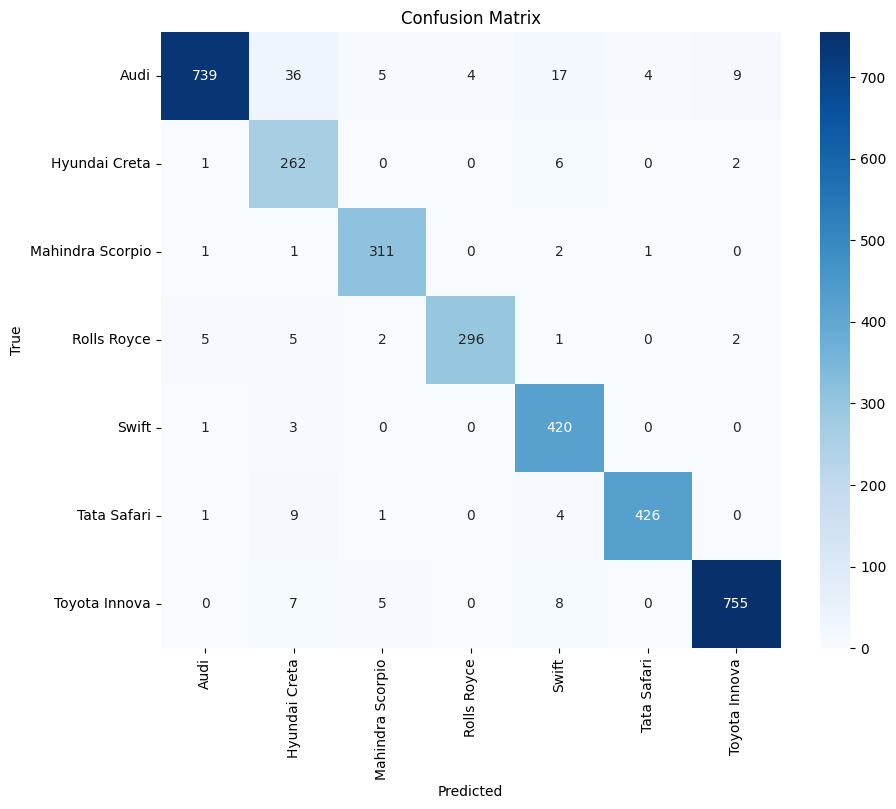

In [13]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [14]:
# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))


Classification Report:
                  precision    recall  f1-score   support

            Audi       0.99      0.91      0.95       814
   Hyundai Creta       0.81      0.97      0.88       271
Mahindra Scorpio       0.96      0.98      0.97       316
     Rolls Royce       0.99      0.95      0.97       311
           Swift       0.92      0.99      0.95       424
     Tata Safari       0.99      0.97      0.98       441
   Toyota Innova       0.98      0.97      0.98       775

        accuracy                           0.96      3352
       macro avg       0.95      0.96      0.95      3352
    weighted avg       0.96      0.96      0.96      3352



In [15]:
# Z-Test
z_stat, z_p_value = stats.ttest_1samp(predicted_labels - true_labels, 0)
print(f"Z-Test: Z={z_stat:.2f}, p-value={z_p_value:.4f}")


Z-Test: Z=2.03, p-value=0.0422


In [16]:
# T-Test
t_stat, t_p_value = stats.ttest_rel(predicted_labels, true_labels)
print(f"T-Test: T={t_stat:.2f}, p-value={t_p_value:.4f}")


T-Test: T=2.03, p-value=0.0422


In [17]:
# ANOVA Test
anova_stat, anova_p_value = stats.f_oneway(predicted_labels, true_labels)
print(f"ANOVA Test: F={anova_stat:.2f}, p-value={anova_p_value:.4f}")


ANOVA Test: F=0.18, p-value=0.6740


In [18]:
# Type 1 & Type 2 Errors
false_positives = np.sum((predicted_labels != true_labels) & (true_labels == 0))
false_negatives = np.sum((predicted_labels != true_labels) & (true_labels == 1))
total_samples = len(true_labels)

type1_error_rate = false_positives / total_samples
type2_error_rate = false_negatives / total_samples

print(f"Type 1 Error Rate: {type1_error_rate:.2f}")
print(f"Type 2 Error Rate: {type2_error_rate:.2f}")


Type 1 Error Rate: 0.02
Type 2 Error Rate: 0.00


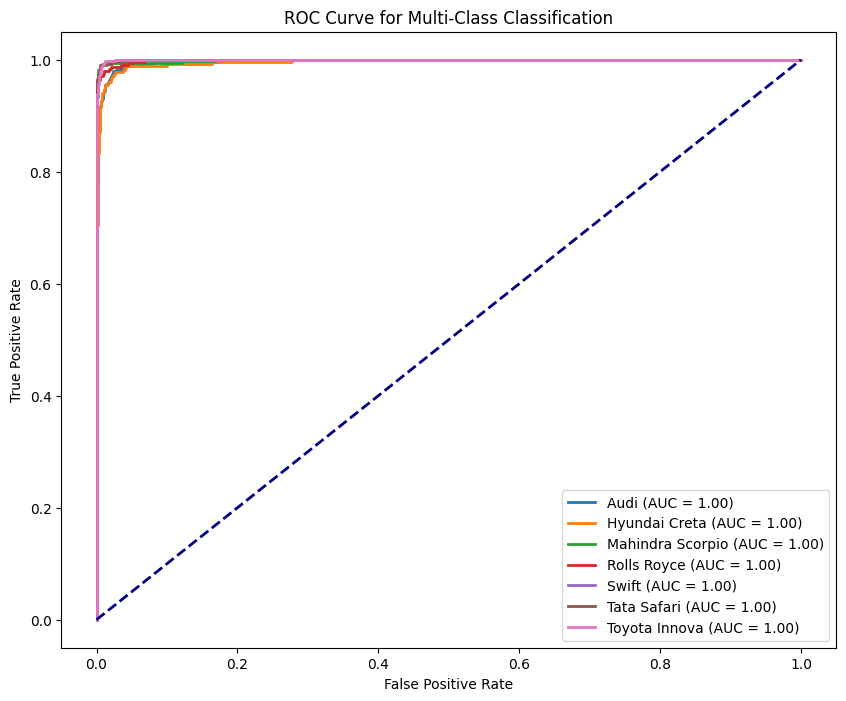

In [19]:
# ROC Curve (One-vs-Rest for Multi-Class)
# Binarize the labels for multi-class ROC curve
true_labels_bin = label_binarize(true_labels, classes=np.arange(num_classes))

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], predicted_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# Plot ROC curve (Random Classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


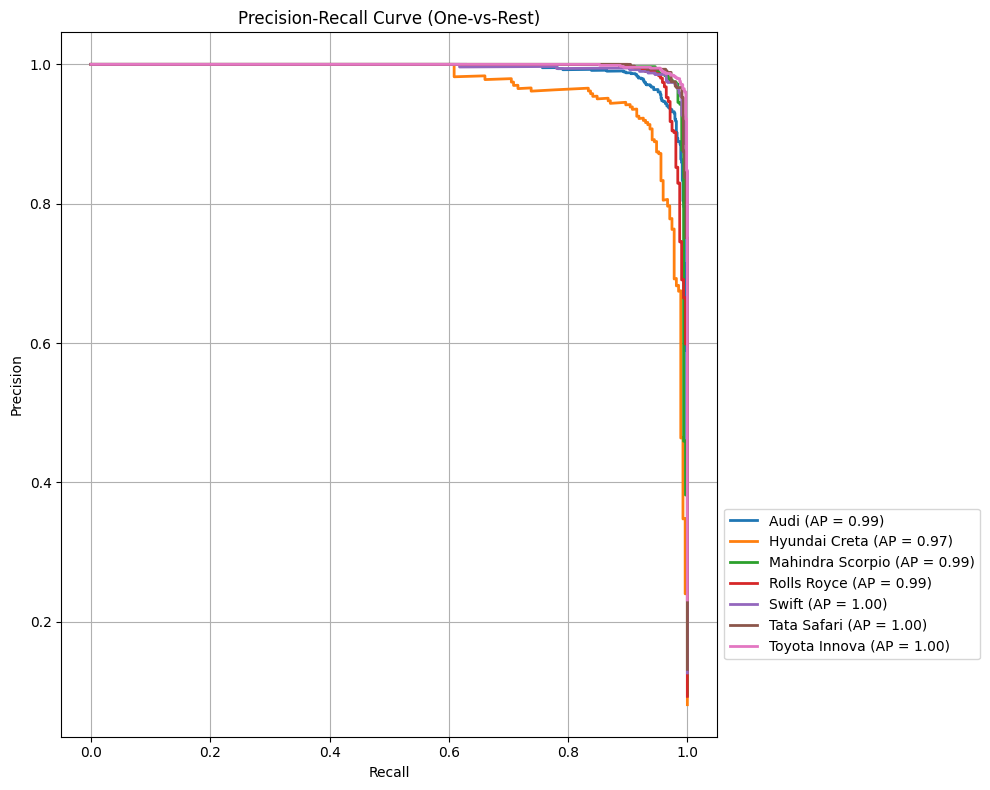

In [20]:
# Precision-Recall Curve
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(true_labels_bin[:, i], predicted_probs[:, i])
    avg_precision = average_precision_score(true_labels_bin[:, i], predicted_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'{class_names[i]} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest)')
plt.legend(loc="lower left", bbox_to_anchor=(1.0, 0.1))
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# Mean Average Precision
mean_ap = average_precision_score(true_labels_bin, predicted_probs, average="macro")
print(f"Mean Average Precision (mAP): {mean_ap:.2f}")


Mean Average Precision (mAP): 0.99
